0.0
511.9717831630174
Creating RawArray with float64 data, n_channels=33, n_times=97792
    Range : 0 ... 97791 =      0.000 ...   190.998 secs
Ready.


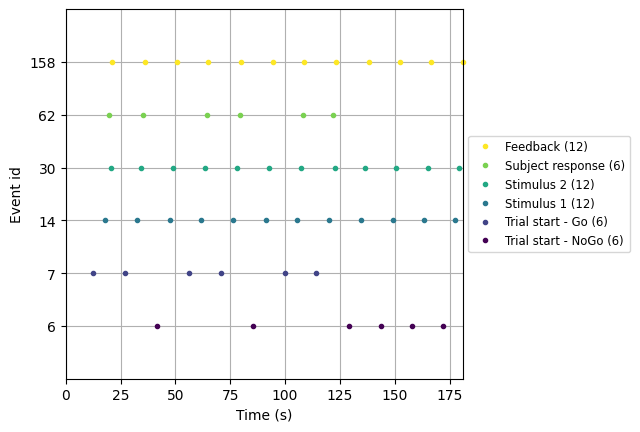

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
0.0
512.0026013677888
Creating RawArray with float64 data, n_channels=33, n_times=94728
    Range : 0 ... 94727 =      0.000 ...   185.014 secs
Ready.


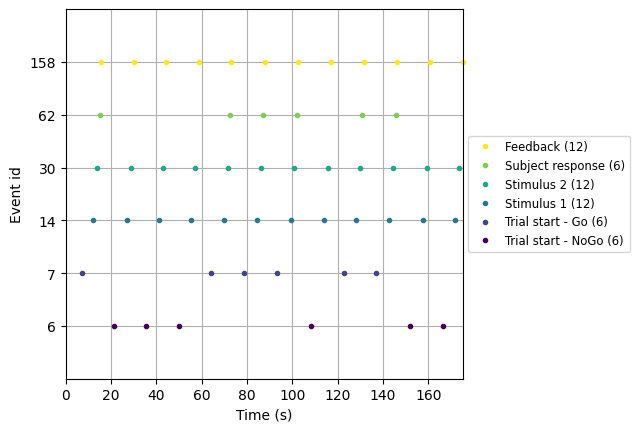

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
0.0
511.9864466816541
Creating RawArray with float64 data, n_channels=33, n_times=98299
    Range : 0 ... 98298 =      0.000 ...   191.988 secs
Ready.


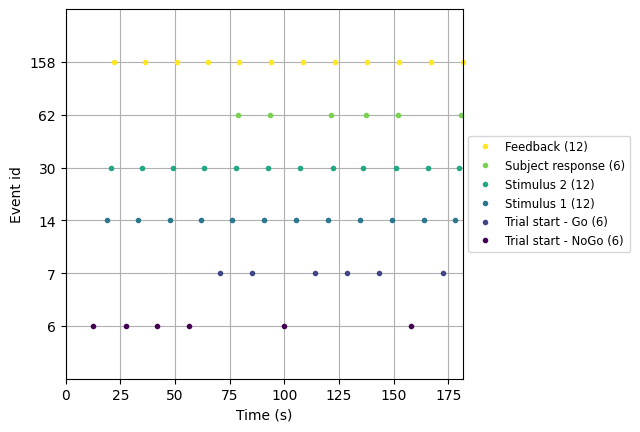

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
0.0
511.9822820490009
Creating RawArray with float64 data, n_channels=33, n_times=95493
    Range : 0 ... 95492 =      0.000 ...   186.508 secs
Ready.


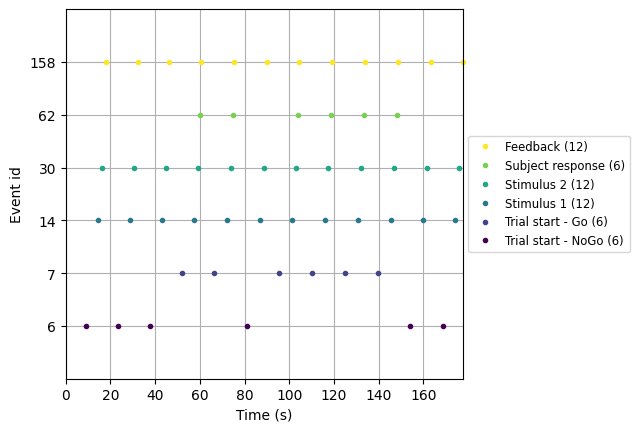

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
0.0
511.9805374703066
Creating RawArray with float64 data, n_channels=33, n_times=95485
    Range : 0 ... 95484 =      0.000 ...   186.492 secs
Ready.


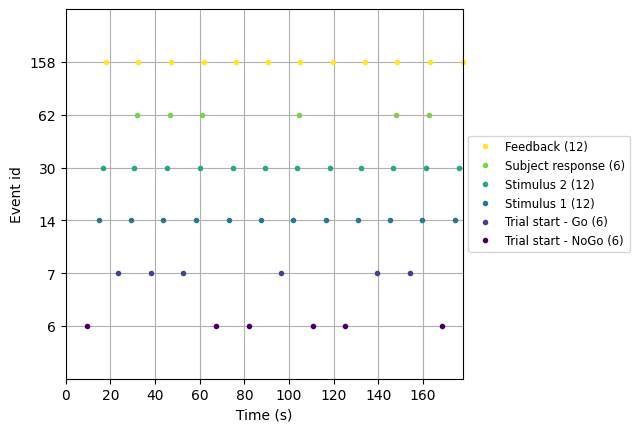

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
0.0
511.93923639392875
Creating RawArray with float64 data, n_channels=33, n_times=97526
    Range : 0 ... 97525 =      0.000 ...   190.479 secs
Ready.


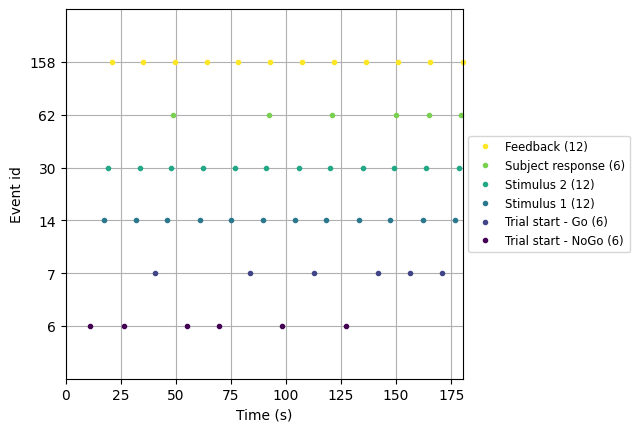

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
Need more than one channel to make topography for eeg. Disabling interactivity.


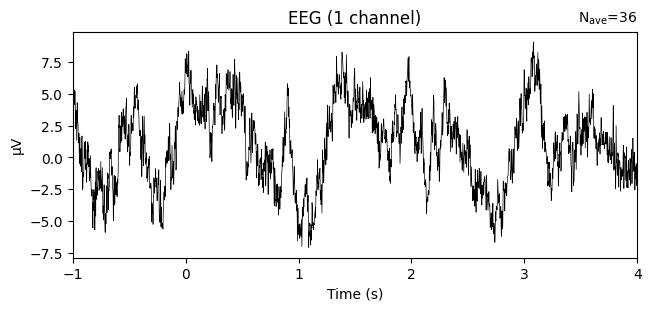

Need more than one channel to make topography for eeg. Disabling interactivity.


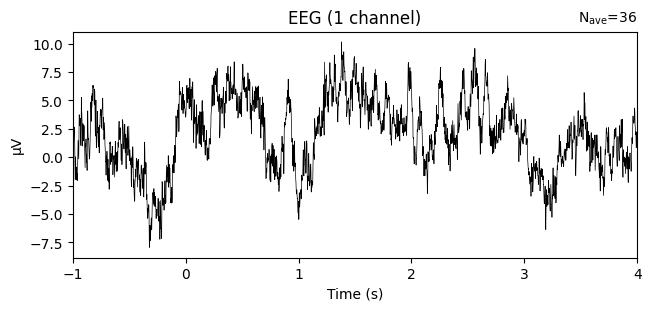

In [2]:
# Effective stream must be greater than 1Hz 
import mne
import numpy as np
import pyxdf
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os

# Function to get stream indices based on type
def get_stream_indices(streams, type_data, type_trig):
    i_data, i_trig = -1, -1
    for i, stream in enumerate(streams):
        stream_type = stream['info']['type'][0].lower()
        effective_srate = float(stream['info']['effective_srate'])
        print(effective_srate)
        if type_data in stream_type:
            i_data = i
        # if type_trig in stream_type and effective_srate > 0: ## use for sub-yy1
        if type_trig in stream_type: # use for all other subjects
            i_trig = i
    return i_data, i_trig

# Load XDF files iteratively from the folder
folder_name = os.path.join(os.getcwd(), 'data', 'subj1')
files = [f for f in os.listdir(folder_name) if f.endswith(".xdf")]

all_go_epochs = []
all_nogo_epochs = []

for file in files:
    file_name = os.path.join(folder_name, file)
    streams, header = pyxdf.load_xdf(file_name)

    # Automatically determine the indices for each file
    i_data, i_trig = get_stream_indices(streams, 'eeg', 'stim')

    # Extract EEG data
    data = np.array(streams[i_data]["time_series"]).T
    sfreq = float(streams[i_data]["info"]["nominal_srate"][0])
    n_chan = 32
    data_times = np.array(streams[i_data]["time_stamps"])

    # Convert to volts (if data is in microvolts)
    data /= 1e6

    # Extract trigger data
    trig = np.array(streams[i_trig]["time_series"]).astype(int)
    trig_times = np.array(streams[i_trig]["time_stamps"])

    # Interpolate trigger data to match the EEG data sampling rate
    interp_func = interp1d(trig_times, trig.flatten(), kind='nearest', fill_value="extrapolate")
    trigger_resampled = interp_func(np.arange(len(data[0])) / sfreq + data_times[0])

    # Append the trigger channel to the EEG data
    data_with_trigger = np.vstack((data[0:n_chan, :], trigger_resampled))

    # Create channel names variable
    channel_names = [ch['label'][0] for ch in streams[i_data]['info']['desc'][0]['channels'][0]['channel'] if ch['type'][0] == 'EEG'] + ['TRIGGER']

    # Create MNE info and RawArray for EEG data with trigger channel
    info = mne.create_info(
        ch_names=channel_names,
        sfreq=sfreq,
        ch_types=['eeg'] * n_chan + ['stim']
    )
    raw_data = mne.io.RawArray(data_with_trigger, info)

    # Manually create events array from trigger channel
    trig_diff = np.diff(trigger_resampled)
    events_indices = np.where(trig_diff != 0)[0] + 1
    events = np.column_stack((events_indices, np.zeros(len(events_indices)), trigger_resampled[events_indices].astype(int)))
    events = events.astype(int)

    # Print and plot events
    unique_events = np.unique(events[:, 2])
    event_colors = dict(zip(unique_events, plt.cm.viridis(np.linspace(0, 1, len(unique_events)))))
    event_dict = {
        "Trial start - NoGo": 6,
        "Trial start - Go": 7,
        "Stimulus 1": 14,
        "Stimulus 2": 30,
        "Subject response": 62,
        "Feedback": 158,
    }
    color_dict = {event: color for event, color in zip(unique_events, plt.cm.viridis(np.linspace(0, 1, len(unique_events))))}
    mne.viz.plot_events(events, sfreq=sfreq, color=color_dict, event_id=event_dict)

    # Create epochs for event_id 14
    event_id = {'14': 14}
    epochs = mne.Epochs(raw_data, events, event_id=event_id, tmin=-1.0, tmax=4.0, baseline=(None, 0), detrend=1, picks=['CZ'], preload=True)

    # Identify trials where event 14 follows a 7 (Go) or 6 (NoGo)
    go_trials = [i for i in range(len(events) - 1) if events[i, 2] == 7 and events[i + 1, 2] == 14]
    nogo_trials = [i for i in range(len(events) - 1) if events[i, 2] == 6 and events[i + 1, 2] == 14]

    # Convert to indices relative to epochs and ensure 1-based indexing
    go_trials = [epochs.selection.tolist().index(i + 1) for i in go_trials if i + 1 in epochs.selection]
    nogo_trials = [epochs.selection.tolist().index(i + 1) for i in nogo_trials if i + 1 in epochs.selection]

    # Select epochs for Go and NoGo
    go_epochs = epochs[go_trials]
    nogo_epochs = epochs[nogo_trials]

    # Append to all epochs list
    all_go_epochs.append(go_epochs)
    all_nogo_epochs.append(nogo_epochs)

# Concatenate all epochs
all_go_epochs = mne.concatenate_epochs(all_go_epochs)
all_nogo_epochs = mne.concatenate_epochs(all_nogo_epochs)

# Average the concatenated epochs
go_evoked = all_go_epochs.average()
nogo_evoked = all_nogo_epochs.average()

# Plot Go ERP
fig_go = go_evoked.plot(picks=['CZ'])
fig_go.suptitle('ERP for Event ID 14 Followed by Go', fontsize=16)

# Plot NoGo ERP
fig_nogo = nogo_evoked.plot(picks=['CZ'])
fig_nogo.suptitle('ERP for Event ID 14 Followed by NoGo', fontsize=16)

# Show plots
plt.show()
